<a href="https://colab.research.google.com/github/Weinihsiang/PTSD-Analysis-using-PCL_C-and-DAIC-Dataset/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

# Paths
input_folder = "/content/drive/MyDrive/PCL_C Dataset"
output_folder = os.path.join(input_folder, "0 and 1")

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# List all CSV files
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

for file_name in csv_files:
    file_path = os.path.join(input_folder, file_name)

    # Read CSV
    df = pd.read_csv(file_path)

    # Keep first column, 2nd-18th, 19th, and 20th column
    df_new = df.iloc[:, [0] + list(range(1, 19)) + [19]].copy()

    # Binary transformation
    df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)
    df_new.iloc[:, 18] = df_new.iloc[:, 18].apply(lambda x: 0 if x <= 30 else 1)

    # Save to output folder
    df_new.to_csv(os.path.join(output_folder, "binary_"+file_name), index=False)

    print(f"Processed {file_name}")

print("All files processed!")


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL-C Labels.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_Llama4.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_DeepSeek.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_Claude_4.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_GPT4o.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_GPT5.csv


/tmp/ipython-input-288992531.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_new.iloc[:, 1:18] = df_new.iloc[:, 1:18].applymap(lambda x: 0 if x in [1,2] else 1)


Processed PCL_C_Gemini.csv
All files processed!


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

# ------------------------
# Single model evaluation
# ------------------------
def evaluate_model(model_name, ground_truth_path, prediction_path, save_folder="/content/drive/MyDrive/PCL_C Dataset/results"):
    # Make sure results folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Load data
    df_true = pd.read_csv(ground_truth_path)
    df_pred = pd.read_csv(prediction_path)

    # The 17 PCL-C category columns
    pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]

    # Clean labels (remove prefix)
    clean_cols = [col.split("_", 2)[-1] for col in pcl_cols]
    clean_cols = [col.replace("_", "") for col in pcl_cols]

    clean_cols = [
      re.sub(r'(?<!^)(?=[A-Z])', ' ', col.split("_", 2)[-1].replace("_", ""))
      for col in pcl_cols
    ]



    # Metrics storage
    metrics = {
        "Category": [],
        "Accuracy": [],
        "F1 Score": [],
        "MCC": []
    }

    # Compute metrics for each category
    for col, clean in zip(pcl_cols, clean_cols):
        y_true = df_true[col]
        y_pred = df_pred[col]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="weighted")
        mcc = matthews_corrcoef(y_true, y_pred)

        metrics["Category"].append(clean)
        metrics["Accuracy"].append(acc)
        metrics["F1 Score"].append(f1)
        metrics["MCC"].append(mcc)

    # Convert results to DataFrame
    results_df = pd.DataFrame(metrics)

    # Save results as CSV
    csv_path = os.path.join(save_folder, f"{model_name}_metrics.csv")
    results_df.to_csv(csv_path, index=False)

    # Plot each metric
    for metric in ["Accuracy", "F1 Score", "MCC"]:
        plt.figure(figsize=(12, 6))
        plt.bar(results_df["Category"], results_df[metric], color="red")
        plt.xticks(rotation=45, ha="right", fontsize=14)
        plt.ylabel(metric, fontsize=16)
        plt.title(f"{model_name} - {metric} per Category", fontsize=18)
        plt.tight_layout()

        # Save plot
        plot_path = os.path.join(save_folder, f"{model_name}_{metric}.png")
        plt.savefig(plot_path, dpi=300)
        plt.close()

    print(f"✅ Results saved in: {save_folder}")
    # ============================
    # 🧠 PTSD Descriptive Statistics (Detailed per Category)
    # ============================
    pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]

    # Calculate total score
    df_true["PCL_Total"] = df_true[pcl_cols].sum(axis=1)

    # (1) Percentage of participants with item score ≥ 3 for each category
    item_percentages = (df_true[pcl_cols] >= 3).mean() * 100  # column-wise percentage

    # (2) Overall percentage of participants with total score ≥ 35
    total_positive_rate = (df_true["PCL_Total"] >= 35).mean() * 100

    # Clean column labels (remove "PCL-C_" and underscores)
    clean_cols = [col.replace("PCL-C_", "").replace("_", "") for col in pcl_cols]


    return results_df




In [ ]:
import os
import re
import pandas as pd

# === Configuration ===
ground_truth_path = "/content/detailed_lables (1).csv"
save_folder = "/content/drive/MyDrive/PCL_C Dataset/results"

# Make sure the folder exists
os.makedirs(save_folder, exist_ok=True)

# Load the correct ground truth file
df_true = pd.read_csv(ground_truth_path)

# Print basic info
print("===== Dataset Information =====")
print(f"📊 Total participants (rows): {len(df_true)}")
print(f"📋 Total columns: {len(df_true.columns)}")

# Identify the 17 PCL-C columns
pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]
print(f"🧩 PCL-C category columns found: {len(pcl_cols)}")

# (1) Compute total PCL score
df_true["PCL_Total"] = df_true[pcl_cols].sum(axis=1)

# (2) Percentage of participants with item score ≥ 3 (per category)
item_percentages = (df_true[pcl_cols] >= 3).mean() * 100  # column-wise percentage

# (3) Overall percentage with total score ≥ 35
total_positive_rate = (df_true["PCL_Total"] >= 35).mean() * 100

# (4) Clean the column labels for readability
clean_cols = [
    re.sub(r'(?<!^)(?=[A-Z])', ' ', col.split("_", 2)[-1].replace("_", ""))
    for col in pcl_cols
]

# (5) Combine into summary DataFrame
summary_df = pd.DataFrame({
    "PCL-C Item": clean_cols,
    "≥3 Percentage (%)": item_percentages.values.round(2)
})

# (6) Add total screening rate row
summary_df.loc[len(summary_df)] = ["Total Score ≥35", round(total_positive_rate, 2)]

# (7) Save results
save_path = os.path.join(save_folder, "PTSD_Item_Level_Stats.csv")
summary_df.to_csv(save_path, index=False)

# (8) Print output
print("\n===== PTSD Descriptive Statistics by Item =====")
print(summary_df)
print(f"\n📁 Saved detailed stats to: {save_path}")


===== Dataset Information =====
📊 Total participants (rows): 275
📋 Total columns: 33
🧩 PCL-C category columns found: 17

===== PTSD Descriptive Statistics by Item =====
             PCL-C Item  ≥3 Percentage (%)
0              Memories              35.27
1                Dreams              25.45
2              Reliving              25.45
3                 Upset              37.45
4              Physical              28.00
5     Thought Avoidance              36.36
6    Activity Avoidance              29.45
7   Trouble Remembering              20.00
8           No Interest              32.73
9          Feel Distant              42.18
10            Feel Numb              30.91
11     Future Cut Short              28.73
12                Sleep              41.45
13         Irritability              30.18
14        Concentration              34.91
15          Hyper Alert              36.36
16                Jumpy              25.45
17      Total Score ≥35              44.36

📁 Saved detai

In [ ]:
import os
import pandas as pd

# === Configuration ===
ground_truth_path = "/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv"
save_folder = "/content"

# Make sure the folder exists
os.makedirs(save_folder, exist_ok=True)

# Load the correct ground truth file
df_true = pd.read_csv(ground_truth_path)

# Identify the 17 PCL-C columns
pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]

# (1) Compute total PCL score
df_true["PCL_Total"] = df_true[pcl_cols].sum(axis=1)

# (2) Percentage of participants with item score ≥ 3 (per category)
item_percentages = (df_true[pcl_cols] >= 3).mean() * 100  # column-wise percentage

# (3) Overall percentage with total score ≥ 35
total_positive_rate = (df_true["PCL_Total"] >= 35).mean() * 100

# (4) Clean the column labels for readability
clean_cols = [col.replace("PCL-C_", "").replace("_", "") for col in pcl_cols]
clean_cols = [
    re.sub(r'(?<!^)(?=[A-Z])', ' ', col.split("_", 2)[-1].replace("_", ""))
    for col in pcl_cols
]

# (5) Combine into summary DataFrame
summary_df = pd.DataFrame({
    "PCL-C Item": clean_cols,
    "≥3 Percentage (%)": item_percentages.values.round(2)
})

# (6) Add total screening rate row
summary_df.loc[len(summary_df)] = ["Total Score ≥35", round(total_positive_rate, 2)]

# (7) Save results
save_path = os.path.join(save_folder, "PTSD_Item_Level_Stats.csv")
summary_df.to_csv(save_path, index=False)

# (8) Print output
print("===== PTSD Descriptive Statistics by Item =====")
print(summary_df)
print(f"📁 Saved detailed stats to: {save_path}")


===== PTSD Descriptive Statistics by Item =====
             PCL-C Item  ≥3 Percentage (%)
0              Memories               42.0
1                Dreams               26.0
2              Reliving               29.0
3                 Upset               44.0
4              Physical               29.0
5     Thought Avoidance               42.0
6    Activity Avoidance               37.0
7   Trouble Remembering               25.0
8           No Interest               45.0
9          Feel Distant               50.0
10            Feel Numb               35.0
11     Future Cut Short               34.0
12                Sleep               50.0
13         Irritability               38.0
14        Concentration               40.0
15          Hyper Alert               34.0
16                Jumpy               28.0
17      Total Score ≥35               52.0
📁 Saved detailed stats to: /content/PTSD_Item_Level_Stats.csv


In [ ]:
results = evaluate_model(
    model_name="DeepSeek v3.1",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_DeepSeek.csv"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/results
===== PTSD Descriptive Statistics by Item =====
             PCL-C Item  ≥3 Percentage (%)
0             1Memories               42.0
1               2Dreams               26.0
2             3Reliving               29.0
3                4Upset               44.0
4             5Physical               29.0
5     6ThoughtAvoidance               42.0
6    7ActivityAvoidance               37.0
7   8TroubleRemembering               25.0
8           9NoInterest               45.0
9         10FeelDistant               50.0
10           11FeelNumb               35.0
11     12FutureCutShort               34.0
12              13Sleep               50.0
13       14Irritability               38.0
14      15Concentration               40.0
15         16HyperAlert               34.0
16              17Jumpy               28.0
17      Total Score ≥35               52.0
📁 Saved detailed stats to: /content/drive/MyDrive/PCL_C Dataset/result

In [ ]:
results = evaluate_model(
    model_name="Claude 4",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_Claude_4.csv"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/results
===== PTSD Descriptive Statistics by Item =====
             PCL-C Item  ≥3 Percentage (%)
0             1Memories               42.0
1               2Dreams               26.0
2             3Reliving               29.0
3                4Upset               44.0
4             5Physical               29.0
5     6ThoughtAvoidance               42.0
6    7ActivityAvoidance               37.0
7   8TroubleRemembering               25.0
8           9NoInterest               45.0
9         10FeelDistant               50.0
10           11FeelNumb               35.0
11     12FutureCutShort               34.0
12              13Sleep               50.0
13       14Irritability               38.0
14      15Concentration               40.0
15         16HyperAlert               34.0
16              17Jumpy               28.0
17      Total Score ≥35               52.0
📁 Saved detailed stats to: /content/drive/MyDrive/PCL_C Dataset/result

In [ ]:
results = evaluate_model(
    model_name="Llama4 Scout",
    ground_truth_path="/content/detailed_lables (1).csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_Llama4.csv"
)

ValueError: Found input variables with inconsistent numbers of samples: [275, 100]

In [ ]:
results = evaluate_model(
    model_name="GPT 4o",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT4o.csv"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/results


In [ ]:
results = evaluate_model(
    model_name="GPT 5",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT5.csv"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/results


In [ ]:
results = evaluate_model(
    model_name="Gemini 2.5 flash",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/PCL_C_Gemini.csv"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/results


Binary

In [ ]:

results = evaluate_model(
    model_name="DeepSeek v3.1",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_DeepSeek.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results
===== PTSD Descriptive Statistics by Item =====
             PCL-C Item  ≥3 Percentage (%)
0             1Memories                0.0
1               2Dreams                0.0
2             3Reliving                0.0
3                4Upset                0.0
4             5Physical                0.0
5     6ThoughtAvoidance                0.0
6    7ActivityAvoidance                0.0
7   8TroubleRemembering                0.0
8           9NoInterest                0.0
9         10FeelDistant                0.0
10           11FeelNumb                0.0
11     12FutureCutShort                0.0
12              13Sleep                0.0
13       14Irritability                0.0
14      15Concentration                0.0
15         16HyperAlert                0.0
16              17Jumpy                0.0
17      Total Score ≥35                0.0
📁 Saved detailed stats to: /content/drive/MyDrive/PCL_C Dataset

In [ ]:

results = evaluate_model(
    model_name="Claude 4",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Claude_4.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results


In [ ]:

results = evaluate_model(
    model_name="Llama4 Scout",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Llama4.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results


In [ ]:

results = evaluate_model(
    model_name="GPT 4o",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT4o.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results


In [ ]:

results = evaluate_model(
    model_name="GPT 5",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT5.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results


In [ ]:

results = evaluate_model(
    model_name="Gemini 2.5 flash",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Gemini.csv",
    save_folder="/content/drive/MyDrive/PCL_C Dataset/binray_results"
)

✅ Results saved in: /content/drive/MyDrive/PCL_C Dataset/binray_results


All Plots

In [ ]:
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef

def evaluate_all_model(model_name, ground_truth_path, prediction_path,
                       save_folder="/content/drive/MyDrive/PCL_C Dataset/all/results", Binary=0):
    # Ensure inputs are lists (max 6)
    if not isinstance(prediction_path, list):
        prediction_path = [prediction_path]
    if not isinstance(model_name, list):
        model_name = [model_name]

    assert len(prediction_path) == len(model_name), "Number of models and prediction files must match"
    assert len(prediction_path) <= 6, "At most 6 models are supported"

    # Make sure results folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Load ground truth
    df_true = pd.read_csv(ground_truth_path)
    pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]
    clean_cols = [col.split("_", 2)[-1].replace("_", "") for col in pcl_cols]
    clean_cols = [
      re.sub(r'(?<!^)(?=[A-Z])', ' ', col.split("_", 2)[-1].replace("_", ""))
      for col in pcl_cols
    ]

    # Store results for all models
    all_results = {}

    for mname, ppath in zip(model_name, prediction_path):
        df_pred = pd.read_csv(ppath)

        metrics = {
            "Category": [],
            "Accuracy": [],
            "F1 Score": [],
            "MCC": []
        }

        # Compute metrics per category
        for col, clean in zip(pcl_cols, clean_cols):
            y_true = df_true[col]
            y_pred = df_pred[col]

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average="weighted")
            mcc = matthews_corrcoef(y_true, y_pred)

            metrics["Category"].append(clean)
            metrics["Accuracy"].append(acc)
            metrics["F1 Score"].append(f1)
            metrics["MCC"].append(mcc)

        results_df = pd.DataFrame(metrics)
        all_results[mname] = results_df

        # Save per-model CSV
        csv_path = os.path.join(save_folder, f"{mname}_metrics.csv")
        results_df.to_csv(csv_path, index=False)

        # Print average metrics across all categories
        avg_acc = results_df["Accuracy"].mean()
        avg_f1  = results_df["F1 Score"].mean()
        avg_mcc = results_df["MCC"].mean()
        print(f"Model: {mname}")
        print(f"  Avg Accuracy: {avg_acc:.4f}")
        print(f"  Avg F1 Score: {avg_f1:.4f}")
        print(f"  Avg MCC: {avg_mcc:.4f}")
        print("-" * 40)

    # ============================
    # 🧪 Statistical Significance Tests
    # ============================
    print("\n===== Statistical Significance Tests =====")

    for metric in ["Accuracy", "F1 Score", "MCC"]:
        print(f"\n--- {metric} ---")
        # Create a matrix of shape (n_models, n_categories)
        data = np.array([all_results[m][metric].values for m in model_name])

        # Friedman test across models
        stat, p_value = friedmanchisquare(*data)
        print(f"Friedman test p-value: {p_value:.5f}")

        # Prepare to store results
        results_list = []

        if p_value < 0.05:
            print("→ Significant differences detected. Running pairwise Wilcoxon tests...")

            # Pairwise comparisons
            pairs = list(combinations(range(len(model_name)), 2))
            p_values = []
            pair_labels = []

            for (i, j) in pairs:
                stat_w, p_w = wilcoxon(data[i], data[j])
                p_values.append(p_w)
                pair_labels.append(f"{model_name[i]} vs {model_name[j]}")

            # Holm correction for multiple comparisons
            reject, p_corrected, _, _ = multipletests(p_values, method='holm')

            # Store and show results
            for label, p_raw, p_adj, sig in zip(pair_labels, p_values, p_corrected, reject):
                sig_mark = "Significant" if sig else "Not Significant"
                print(f"{label:<35} raw p={p_raw:.5f}, corrected p={p_adj:.5f} ({sig_mark})")
                results_list.append({
                    "Comparison": label,
                    "Raw p-value": p_raw,
                    "Holm-corrected p-value": p_adj,
                    "Significant": sig_mark
                })
        else:
            print("→ No significant differences found.")
            results_list.append({
                "Comparison": "N/A",
                "Raw p-value": p_value,
                "Holm-corrected p-value": p_value,
                "Significant": "No significant differences"
            })

        # Add Friedman result at top
        results_df = pd.DataFrame(results_list)
        results_df.loc[-1] = {
            "Comparison": "Friedman Test (Overall)",
            "Raw p-value": p_value,
            "Holm-corrected p-value": np.nan,
            "Significant": "Yes" if p_value < 0.05 else "No"
        }
        results_df.index = results_df.index + 1
        results_df = results_df.sort_index()

        # Save to CSV
        stats_csv_path = os.path.join(save_folder, f"Statistical_Tests_{metric.replace(' ', '_')}.csv")
        results_df.to_csv(stats_csv_path, index=False)
        print(f"📁 Saved statistical test results to: {stats_csv_path}")


    # Colors for up to 6 models
    colors = ["red", "blue", "green", "orange", "purple", "brown"]

    # Plot comparison for each metric

    # Plot comparison for each metric
    for metric in ["Accuracy", "F1 Score", "MCC"]:
        plt.figure(figsize=(12, 6))

        combined_values = []  # store values per model for averaging
        x = np.arange(len(clean_cols))  # category positions
        bar_width = 0.8 / len(model_name)  # space bars evenly

        # Plot bars for each model
        for idx, mname in enumerate(model_name):
            results_df = all_results[mname]
            plt.bar(x + idx * bar_width, results_df[metric],
                    width=bar_width, color=colors[idx], label=mname)
            combined_values.append(results_df[metric].values)

        # Compute average across models (per category)
        avg_metric = pd.DataFrame(combined_values).mean(axis=0)

        # Plot average line with star markers
        plt.plot(x + (len(model_name) - 1) * bar_width / 2, avg_metric,
                 marker="*", markersize=8, color="black", linewidth=1, label="Average")

        plt.xticks(x + (len(model_name) - 1) * bar_width / 2, clean_cols,
                   rotation=45, ha="right", fontsize=14)
        plt.ylabel(metric, fontsize=16)

        # ✅ Fixed y-axis between 0 and 1.0
        plt.ylim(0, 1.0)

        # Title with Binary condition
        binary_text = "Binary " if Binary == 1 else "Score 1-5 "
        plt.title(f"Comparison of PCL-C Sub-labels {binary_text}{metric}", fontsize=18)
        plt.legend(
            fontsize=12,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.0),
            ncol=7,
            frameon=False,
            handletextpad=0.5,
            columnspacing=0.7,
            labelspacing=0.4
        )

        plt.tight_layout()

        # Save bar plot
        plot_name = f"Comparison_{metric}{'_Binary' if Binary == 1 else ''}"
        plt.savefig(os.path.join(save_folder, f"{plot_name}.png"), dpi=300)
        plt.close()

        # ---- CSV with values shown on plot ----
        combined_csv = pd.DataFrame({"Category": clean_cols})
        for mname, df in all_results.items():
            combined_csv[mname] = df[metric].values
        combined_csv["Average"] = avg_metric.values
        combined_csv.to_csv(os.path.join(save_folder, f"{plot_name}.csv"), index=False)
        # ---------------------------------------

        # ✅ NEW: Create a boxplot per metric across all models
        plt.figure(figsize=(10, 6))
        data_for_boxplot = [all_results[m][metric].values for m in model_name]

        plt.boxplot(data_for_boxplot, patch_artist=True,
                    boxprops=dict(facecolor='white', color='gray'),
                    medianprops=dict(color='orange', linewidth=1.5),
                    whiskerprops=dict(color='gray'),
                    capprops=dict(color='gray'),
                    flierprops=dict(marker='o', color='gray', markersize=4))

        plt.xticks(np.arange(1, len(model_name)+1), model_name, fontsize=12)
        plt.ylabel(metric, fontsize=14)
        plt.title(f"PCL-C {metric} Boxplot {'(Binary)' if Binary==1 else '(1-5)'}", fontsize=16)
        plt.tight_layout()

        # Save boxplot
        boxplot_name = f"Boxplot_{metric}{'_Binary' if Binary == 1 else ''}.png"
        plt.savefig(os.path.join(save_folder, boxplot_name), dpi=300)
        plt.close()

        # ---- CSV with values shown on plot ----
        combined_csv = pd.DataFrame({"Category": clean_cols})
        for mname, df in all_results.items():
            combined_csv[mname] = df[metric].values
        combined_csv["Average"] = avg_metric.values

        csv_path = os.path.join(save_folder, f"{plot_name}.csv")
        combined_csv.to_csv(csv_path, index=False)
        # ---------------------------------------

    print(f"✅ Results saved in: {save_folder}")
    return all_results


In [ ]:
results = evaluate_all_model(
    model_name=["DeepSeek3.1", "Claude4", "Llama4", "GPT4o", "GPT5", "Gemini2.5"],
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path=[
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_DeepSeek.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Claude_4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Llama4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT4o.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT5.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Gemini.csv"
    ],
    save_folder="/content/drive/MyDrive/PCL_C Dataset/all",
    Binary=0
)

Model: DeepSeek3.1
  Avg Accuracy: 0.4382
  Avg F1 Score: 0.3478
  Avg MCC: 0.1535
----------------------------------------
Model: Claude4
  Avg Accuracy: 0.4329
  Avg F1 Score: 0.3477
  Avg MCC: 0.1412
----------------------------------------
Model: Llama4
  Avg Accuracy: 0.4188
  Avg F1 Score: 0.3418
  Avg MCC: 0.1335
----------------------------------------
Model: GPT4o
  Avg Accuracy: 0.4076
  Avg F1 Score: 0.2931
  Avg MCC: 0.0788
----------------------------------------
Model: GPT5
  Avg Accuracy: 0.4194
  Avg F1 Score: 0.2955
  Avg MCC: 0.0933
----------------------------------------
Model: Gemini2.5
  Avg Accuracy: 0.4371
  Avg F1 Score: 0.3469
  Avg MCC: 0.1469
----------------------------------------

===== Statistical Significance Tests =====

--- Accuracy ---
Friedman test p-value: 0.04126
→ Significant differences detected. Running pairwise Wilcoxon tests...
DeepSeek3.1 vs Claude4              raw p=0.62801, corrected p=1.00000 (Not Significant)
DeepSeek3.1 vs Llama4      

In [ ]:
results = evaluate_all_model(
    model_name=["DeepSeek3.1", "Claude4", "Llama4", "GPT4o", "GPT5", "Gemini2.5"],
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path=[
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_DeepSeek.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Claude_4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Llama4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT4o.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT5.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Gemini.csv"
    ],
    save_folder="/content/drive/MyDrive/PCL_C Dataset/all",
    Binary=1
)

Model: DeepSeek3.1
  Avg Accuracy: 0.6994
  Avg F1 Score: 0.6528
  Avg MCC: 0.2728
----------------------------------------
Model: Claude4
  Avg Accuracy: 0.7047
  Avg F1 Score: 0.6565
  Avg MCC: 0.2786
----------------------------------------
Model: Llama4
  Avg Accuracy: 0.6941
  Avg F1 Score: 0.6339
  Avg MCC: 0.2493
----------------------------------------
Model: GPT4o
  Avg Accuracy: 0.6818
  Avg F1 Score: 0.6073
  Avg MCC: 0.2152
----------------------------------------
Model: GPT5
  Avg Accuracy: 0.6800
  Avg F1 Score: 0.5975
  Avg MCC: 0.2117
----------------------------------------
Model: Gemini2.5
  Avg Accuracy: 0.6976
  Avg F1 Score: 0.6507
  Avg MCC: 0.2681
----------------------------------------

===== Statistical Significance Tests =====

--- Accuracy ---
Friedman test p-value: 0.00630
→ Significant differences detected. Running pairwise Wilcoxon tests...
DeepSeek3.1 vs Claude4              raw p=0.55115, corrected p=1.00000 (Not Significant)
DeepSeek3.1 vs Llama4      

Calculating M+-SD

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score

def calculate_all_model(model_name, ground_truth_path, prediction_path,
                   save_folder="/content/drive/MyDrive/PCL_C Dataset/all/results", Binary=0):
    """
    Evaluate one or multiple models against ground truth labels.
    Save results in CSV format with mean ± std for each metric.
    """

    # Ensure inputs are lists (max 6)
    if not isinstance(prediction_path, list):
        prediction_path = [prediction_path]
    if not isinstance(model_name, list):
        model_name = [model_name]

    assert len(prediction_path) == len(model_name), "Number of models and prediction files must match"
    assert len(prediction_path) <= 6, "At most 6 models are supported"

    # Make sure results folder exists
    os.makedirs(save_folder, exist_ok=True)

    # Load ground truth
    df_true = pd.read_csv(ground_truth_path)
    pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]

    summary_rows = []

    for mname, ppath in zip(model_name, prediction_path):
        df_pred = pd.read_csv(ppath)

        precision_vals, recall_vals, acc_vals, f1_vals, mcc_vals = [], [], [], [], []

        # Compute metrics per category
        for col in pcl_cols:
            y_true = df_true[col]
            y_pred = df_pred[col]

            precision_vals.append(precision_score(y_true, y_pred, average="weighted", zero_division=0))
            recall_vals.append(recall_score(y_true, y_pred, average="weighted", zero_division=0))
            acc_vals.append(accuracy_score(y_true, y_pred))
            f1_vals.append(f1_score(y_true, y_pred, average="weighted", zero_division=0))
            mcc_vals.append(matthews_corrcoef(y_true, y_pred))

        # Format mean ± std
        def fmt(values):
            return f"{np.mean(values):.3f} ± {np.std(values):.3f}"

        summary_rows.append({
            "Model": mname,
            "Precision": fmt(precision_vals),
            "Recall": fmt(recall_vals),
            "Accuracy": fmt(acc_vals),
            "F1-score": fmt(f1_vals),
            "MCC": fmt(mcc_vals)
        })

    # Save summary to CSV
    summary_df = pd.DataFrame(summary_rows)
    csv_path = os.path.join(save_folder, "all_models_metrics_summary.csv")
    summary_df.to_csv(csv_path, index=False)

    print(f"✅ Summary saved to {csv_path}")
    return summary_df


In [ ]:
results = calculate_all_model(
    model_name=["DeepSeek3.1", "Claude4", "Llama4", "GPT4o", "GPT5", "Gemini2.5"],
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_path=[
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_DeepSeek.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Claude_4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Llama4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT4o.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT5.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Gemini.csv"
    ],
    save_folder="/content/drive/MyDrive/PCL_C Dataset/DETAILS",
    Binary=0
)

✅ Summary saved to /content/drive/MyDrive/PCL_C Dataset/DETAILS/all_models_metrics_summary.csv


In [ ]:
results = calculate_all_model(
    model_name=["DeepSeek3.1", "Claude4", "Llama4", "GPT4o", "GPT5", "Gemini2.5"],
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL-C Labels.csv",
    prediction_path=[
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_DeepSeek.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Claude_4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Llama4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT4o.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_GPT5.csv",
        "/content/drive/MyDrive/PCL_C Dataset/0 and 1/binary_PCL_C_Gemini.csv"
    ],
    save_folder="/content/drive/MyDrive/PCL_C Dataset/threecategory/DETAILS/BINARY",
    Binary=1
)

✅ Summary saved to /content/drive/MyDrive/PCL_C Dataset/threecategory/DETAILS/BINARY/all_models_metrics_summary.csv


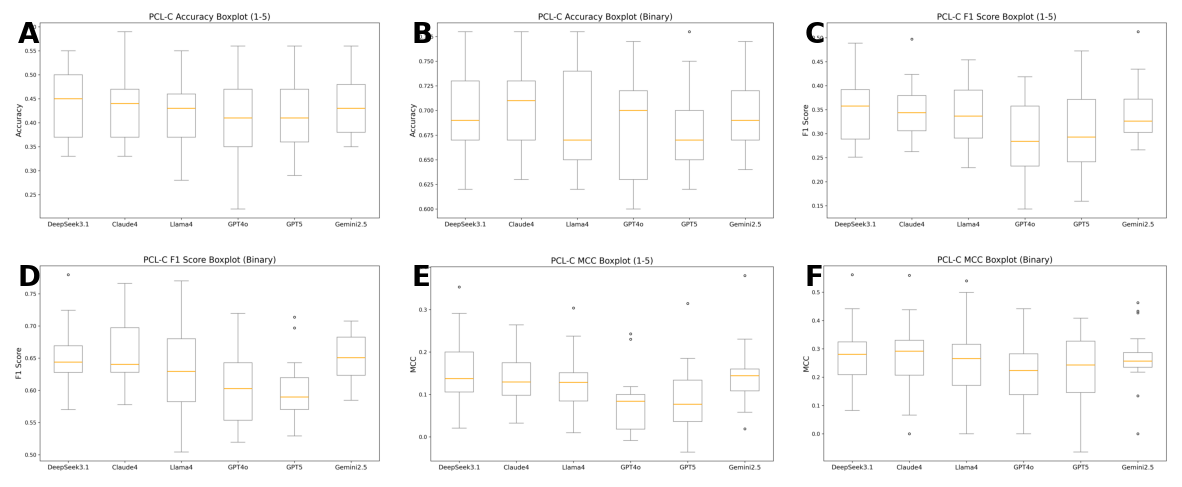

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to your 6 images
image_paths = [
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_Accuracy.png",
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_Accuracy_Binary.png",
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_F1 Score.png",
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_F1 Score_Binary.png",
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_MCC.png",
    "/content/drive/MyDrive/PCL_C Dataset/all/Boxplot_MCC_Binary.png"
]

# Labels for each subplot
labels = ["A", "B", "C", "D", "E", "F"]

# Create a 2x3 figure
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # slightly shorter height

# Adjust spacing between rows and columns
fig.subplots_adjust(wspace=0.05, hspace=-0.35)  # ↓ reduce vertical space here

axes = axes.flatten()

for i, ax in enumerate(axes):
    img = mpimg.imread(image_paths[i])
    ax.imshow(img)
    ax.axis("off")
    ax.text(
        0.02, 0.95, labels[i],
        transform=ax.transAxes,
        fontsize=20,
        fontweight="bold",
        va="top",
        ha="left",
        color="black"
    )

plt.savefig("combined_figure.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from scipy.stats import pearsonr, spearmanr

# =====================================================
# 🔍 Correlation Between Transcript Length and Model Performance
# =====================================================
def correlate_transcript_length_with_performance(
    transcript_path,
    ground_truth_path,
    prediction_paths,
    model_names,
    save_folder="/content/drive/MyDrive/PCL_C Dataset/all/results"
):
    os.makedirs(save_folder, exist_ok=True)

    # ---- Load transcript file ----
    df_trans = pd.read_csv(transcript_path)
    if "Transcript" not in df_trans.columns or "Participant_ID" not in df_trans.columns:
        raise ValueError("Transcript file must contain 'Participant_ID' and 'Transcript' columns")

    # Compute transcript length (word count)
    df_trans["Transcript_Length"] = df_trans["Transcript"].astype(str).apply(lambda x: len(x.split()))
    print(f"📄 Loaded {len(df_trans)} transcripts. Example lengths:\n", df_trans["Transcript_Length"].head())

    # ---- Load ground truth ----
    df_true = pd.read_csv(ground_truth_path)
    pcl_cols = [col for col in df_true.columns if col.startswith("PCL-C_")]

    # Identify participant column
    participant_col = None
    for c in df_true.columns:
        if "participant" in c.lower():
            participant_col = c
            break
    if participant_col is None:
        raise ValueError("No participant column found in ground truth file!")

    correlations_summary = []

    # ---- Loop over models ----
    for mname, ppath in zip(model_names, prediction_paths):
        print(f"\n===== Analyzing {mname} =====")

        df_pred = pd.read_csv(ppath)

        # Match participant column
        if participant_col not in df_pred.columns:
            raise ValueError(f"'{participant_col}' not found in {mname} prediction file")

        # Merge with ground truth and transcript
        df_merged = (
            df_true[[participant_col] + pcl_cols]
            .merge(df_pred[[participant_col] + pcl_cols], on=participant_col, suffixes=("_true", "_pred"))
            .merge(df_trans[["Participant_ID", "Transcript_Length"]],
                   left_on=participant_col, right_on="Participant_ID", how="inner")
        )

        # ---- Compute per-participant performance ----
        metrics_per_row = []
        for _, row in df_merged.iterrows():
            y_true = row[[f"{col}_true" for col in pcl_cols]].values
            y_pred = row[[f"{col}_pred" for col in pcl_cols]].values

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
            mcc = matthews_corrcoef(y_true, y_pred)
            metrics_per_row.append((acc, f1, mcc))

        metrics_df = pd.DataFrame(metrics_per_row, columns=["Accuracy", "F1", "MCC"])
        metrics_df["Transcript_Length"] = df_merged["Transcript_Length"].values

        # ---- Compute correlations ----
        for metric in ["Accuracy", "F1", "MCC"]:
            pearson_r, pearson_p = pearsonr(metrics_df["Transcript_Length"], metrics_df[metric])
            spearman_r, spearman_p = spearmanr(metrics_df["Transcript_Length"], metrics_df[metric])

            print(f"\n📈 {metric}:")
            print(f"   Pearson r = {pearson_r:.3f}, p = {pearson_p:.4f} {'✅ Significant' if pearson_p < 0.05 else '❌ Not significant'}")
            print(f"   Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.4f} {'✅ Significant' if spearman_p < 0.05 else '❌ Not significant'}")

            correlations_summary.append({
                "Model": mname,
                "Metric": metric,
                "Pearson_r": pearson_r,
                "Pearson_p": pearson_p,
                "Spearman_rho": spearman_r,
                "Spearman_p": spearman_p,
                "Significant (Pearson)": "Yes" if pearson_p < 0.05 else "No",
                "Significant (Spearman)": "Yes" if spearman_p < 0.05 else "No"
            })

    # ---- Save summary ----
    summary_df = pd.DataFrame(correlations_summary)
    save_path = os.path.join(save_folder, "TranscriptLength_Correlation.csv")
    summary_df.to_csv(save_path, index=False)

    print(f"\n✅ Correlation summary saved to: {save_path}")
    return summary_df


In [ ]:
results_corr = correlate_transcript_length_with_performance(
    transcript_path="/content/Detailed_PHQ8_Labels (1).csv",
    ground_truth_path="/content/drive/MyDrive/PCL_C Dataset/PCL-C Labels.csv",
    prediction_paths=[
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_DeepSeek.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Claude_4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Llama4.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT4o.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_GPT5.csv",
        "/content/drive/MyDrive/PCL_C Dataset/PCL_C_Gemini.csv"
    ],
    model_names=["DeepSeek3.1", "Claude4", "Llama4", "GPT4o", "GPT5", "Gemini2.5"],
    save_folder="/content/drive/MyDrive/PCL_C Dataset/all"
)


📄 Loaded 219 transcripts. Example lengths:
 0     998
1    2035
2    1231
3    2604
4    1692
Name: Transcript_Length, dtype: int64

===== Analyzing DeepSeek3.1 =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



📈 Accuracy:
   Pearson r = 0.107, p = 0.2899 ❌ Not significant
   Spearman ρ = 0.163, p = 0.1044 ❌ Not significant

📈 F1:
   Pearson r = 0.132, p = 0.1908 ❌ Not significant
   Spearman ρ = 0.192, p = 0.0553 ❌ Not significant

📈 MCC:
   Pearson r = 0.027, p = 0.7901 ❌ Not significant
   Spearman ρ = 0.081, p = 0.4224 ❌ Not significant

===== Analyzing Claude4 =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



📈 Accuracy:
   Pearson r = 0.065, p = 0.5186 ❌ Not significant
   Spearman ρ = 0.107, p = 0.2884 ❌ Not significant

📈 F1:
   Pearson r = 0.095, p = 0.3480 ❌ Not significant
   Spearman ρ = 0.135, p = 0.1800 ❌ Not significant

📈 MCC:
   Pearson r = -0.054, p = 0.5928 ❌ Not significant
   Spearman ρ = 0.029, p = 0.7741 ❌ Not significant

===== Analyzing Llama4 =====

📈 Accuracy:
   Pearson r = 0.072, p = 0.4762 ❌ Not significant
   Spearman ρ = 0.098, p = 0.3330 ❌ Not significant

📈 F1:
   Pearson r = 0.117, p = 0.2460 ❌ Not significant
   Spearman ρ = 0.144, p = 0.1542 ❌ Not significant

📈 MCC:
   Pearson r = -0.085, p = 0.3979 ❌ Not significant
   Spearman ρ = -0.128, p = 0.2047 ❌ Not significant

===== Analyzing GPT4o =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



📈 Accuracy:
   Pearson r = 0.084, p = 0.4074 ❌ Not significant
   Spearman ρ = 0.123, p = 0.2231 ❌ Not significant

📈 F1:
   Pearson r = 0.135, p = 0.1814 ❌ Not significant
   Spearman ρ = 0.183, p = 0.0682 ❌ Not significant

📈 MCC:
   Pearson r = -0.001, p = 0.9883 ❌ Not significant
   Spearman ρ = 0.043, p = 0.6720 ❌ Not significant

===== Analyzing GPT5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(



📈 Accuracy:
   Pearson r = 0.091, p = 0.3695 ❌ Not significant
   Spearman ρ = 0.115, p = 0.2538 ❌ Not significant

📈 F1:
   Pearson r = 0.129, p = 0.2020 ❌ Not significant
   Spearman ρ = 0.137, p = 0.1750 ❌ Not significant

📈 MCC:
   Pearson r = -0.014, p = 0.8904 ❌ Not significant
   Spearman ρ = -0.046, p = 0.6502 ❌ Not significant

===== Analyzing Gemini2.5 =====


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use th


📈 Accuracy:
   Pearson r = 0.029, p = 0.7715 ❌ Not significant
   Spearman ρ = 0.050, p = 0.6235 ❌ Not significant

📈 F1:
   Pearson r = 0.043, p = 0.6674 ❌ Not significant
   Spearman ρ = 0.054, p = 0.5926 ❌ Not significant

📈 MCC:
   Pearson r = -0.053, p = 0.6008 ❌ Not significant
   Spearman ρ = -0.013, p = 0.8978 ❌ Not significant

✅ Correlation summary saved to: /content/drive/MyDrive/PCL_C Dataset/all/TranscriptLength_Correlation.csv
